### https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT
### https://dengjunquan.github.io/posts/2018/08/DoAEstimation_Python/

Actual DoAs: [-1.43980251 -1.23258289 -0.52785101  1.00917105  1.23420657] 

MUSIC DoAs: [-1.44828296 -1.23826006 -0.52943275  1.01073524  1.2295091 ] 

ESPRIT DoAs: [-1.46158889 -1.25290696 -0.52888744  1.00832902  1.23919309] 



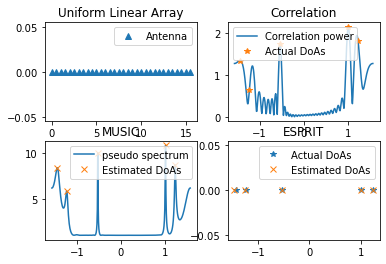

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
import operator

# Functions
def array_response_vector(array,theta):
    N = array.shape
    v = np.exp(1j*2*np.pi*array*np.sin(theta))
    return v/np.sqrt(N)

def music(CovMat,L,N,array,Angles):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array_response_vector(array,Angles[i])
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    DoAsMUSIC,_= ss.find_peaks(psindB,height=1.35, distance=1.5)
    return DoAsMUSIC,pspectrum

def esprit(CovMat,L,N):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    _,U = LA.eig(CovMat)
    S = U[:,0:L]
    Phi = LA.pinv(S[0:N-1]) @ S[1:N] # the original array is divided into two subarrays [0,1,...,N-2] and [1,2,...,N-1]
    eigs,_ = LA.eig(Phi)
    DoAsESPRIT = np.arcsin(np.angle(eigs)/np.pi)
    return DoAsESPRIT
#=============================================================

np.random.seed(6)

lamda = 1 # wavelength
kappa = np.pi/lamda # wave number
L = 5  # number of sources
N = 32  # number of ULA elements 
snr = 10 # signal to noise ratio


array = np.linspace(0,(N-1)/2,N)

plt.figure()
plt.subplot(221)
plt.plot(array,np.zeros(N),'^')
plt.title('Uniform Linear Array')
plt.legend(['Antenna'])


Thetas = np.pi*(np.random.rand(L)-1/2)   # random source directions
Alphas = np.random.randn(L) + np.random.randn(L)*1j # random source powers
Alphas = np.sqrt(1/2)*Alphas
#print(Thetas)
#print(Alphas)

h = np.zeros(N)
for i in range(L):
    h = h + Alphas[i]*array_response_vector(array,Thetas[i])

Angles = np.linspace(-np.pi/2,np.pi/2,360)
numAngles = Angles.size

hv = np.zeros(numAngles)
for j in range(numAngles):
    av = array_response_vector(array,Angles[j])
    hv[j] = np.abs(np.inner(h,av.conj()))

powers = np.zeros(L)
for j in range(L):
    av = array_response_vector(array,Thetas[j])
    powers[j] = np.abs(np.inner(h,av.conj()))

plt.subplot(222)
plt.plot(Angles,hv)
plt.plot(Thetas,powers,'*')
plt.title('Correlation')
plt.legend(['Correlation power','Actual DoAs'])
numrealization = 100
H = np.zeros((N,numrealization)) + 1j*np.zeros((N,numrealization))

for iter in range(numrealization):
    htmp = np.zeros(N)
    for i in range(L):
        pha = np.exp(1j*2*np.pi*np.random.rand(1))
        htmp = htmp + pha*Alphas[i]*array_response_vector(array,Thetas[i])
    H[:,iter] = htmp + np.sqrt(0.5/snr)*(np.random.randn(N)+np.random.randn(N)*1j)
CovMat = H@H.conj().transpose()

# MUSIC algorithm
DoAsMUSIC, psindB = music(CovMat,L,N,array,Angles)


plt.subplot(223)
plt.plot(Angles,psindB)
plt.plot(Angles[DoAsMUSIC],psindB[DoAsMUSIC],'x')
plt.title('MUSIC')
plt.legend(['pseudo spectrum','Estimated DoAs'])

# ESPRIT algorithm
DoAsESPRIT = esprit(CovMat,L,N)
plt.subplot(224)
plt.plot(Thetas,np.zeros(L),'*')
plt.plot(DoAsESPRIT,np.zeros(L),'x')
plt.title('ESPRIT')
plt.legend(['Actual DoAs','Estimated DoAs'])

print('Actual DoAs:',np.sort(Thetas),'\n')
print('MUSIC DoAs:',np.sort(Angles[DoAsMUSIC]),'\n')
print('ESPRIT DoAs:',np.sort(DoAsESPRIT),'\n')

plt.show()